ERROR: Could not find a version that satisfies the requirement addicts (from versions: none)
ERROR: No matching distribution found for addicts
2025-08-02 18:33:54,675 - INFO - Using device: cpu


✅ VideoMAE imported successfully
❌ ModelScope import error: No module named 'addict'
Install ModelScope: pip install modelscope


2025-08-02 18:33:57,025 - INFO - VideoMAE model loaded: MCG-NJU/videomae-base-finetuned-kinetics
2025-08-02 18:33:57,027 - INFO - ModelScope not available, using fallback video generation
2025-08-02 18:33:57,027 - INFO - Pipeline initialized. Output directory: video_transformation_output
2025-08-02 18:33:57,027 - INFO - 🚀 Starting full video-to-video transformation pipeline
2025-08-02 18:33:57,027 - INFO - Phase 1: Processing 4 input videos
2025-08-02 18:33:57,947 - INFO - Extracted 16 frames from C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair1.mp4
2025-08-02 18:34:00,208 - INFO - Features extracted for C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair1.mp4: torch.Size([1, 768])
2025-08-02 18:34:00,226 - INFO - Added features for C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair1.mp4
2025-08-02 18:34:01,367 - INFO - Extracted 16 frames from C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair2.mp4
2025-08-02 18:34:02,981 - INFO - Features

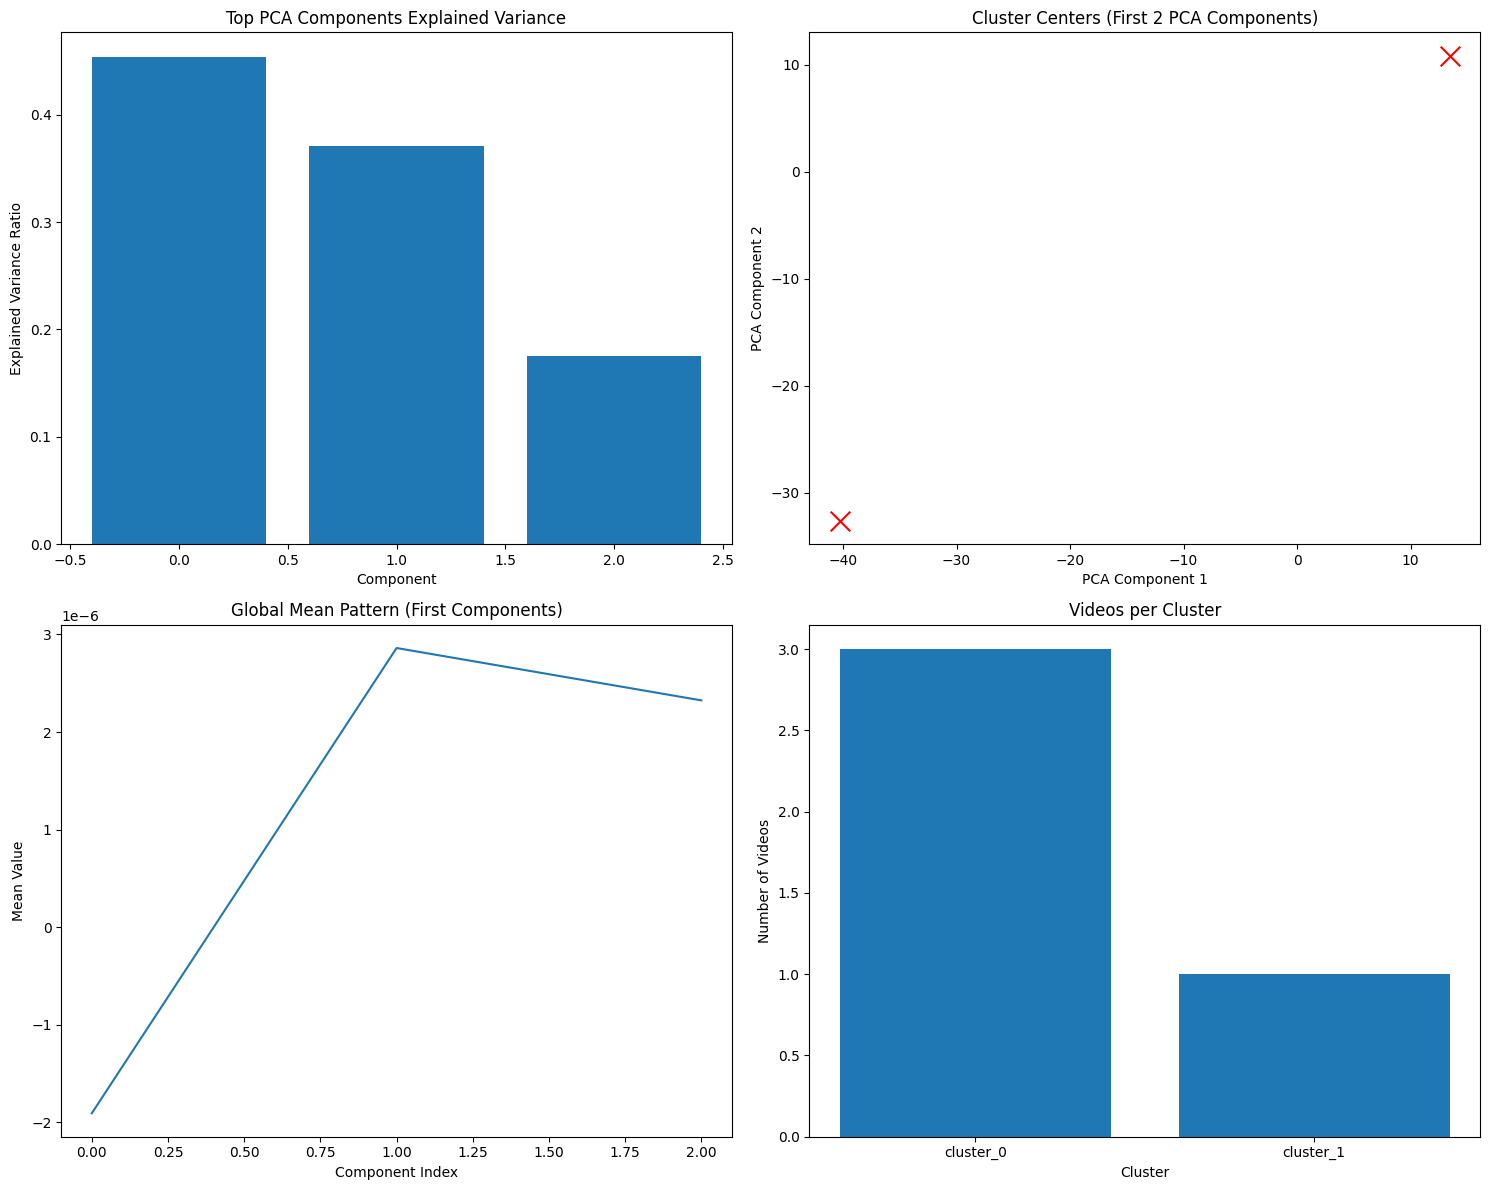

2025-08-02 18:34:10,229 - INFO - Phase 2 complete: Pattern analysis finished
2025-08-02 18:34:10,230 - INFO - Phase 3: Generating 2 new videos
2025-08-02 18:34:10,231 - INFO - Creating pattern-based video using fallback method
2025-08-02 18:34:10,314 - INFO - Pattern-based video created: video_transformation_output\generated_video_1.mp4
2025-08-02 18:34:10,317 - INFO - Creating pattern-based video using fallback method
2025-08-02 18:34:10,366 - INFO - Pattern-based video created: video_transformation_output\generated_video_2.mp4
2025-08-02 18:34:10,367 - INFO - Phase 3 complete: Generated 2 videos
2025-08-02 18:34:10,369 - INFO - Phase 4: Evaluating results
2025-08-02 18:34:10,371 - INFO - Phase 4 complete: Evaluation finished
2025-08-02 18:34:10,372 - INFO - ✅ Pipeline completed successfully!



PIPELINE RESULTS:
pipeline_status: SUCCESS
input_videos: 4
generated_videos: 2
output_directory: video_transformation_output
evaluation: {'input_video_count': 4, 'generated_video_count': 2, 'pattern_clusters': 2, 'feature_dimensions': 768, 'timestamp': '2025-08-02T18:34:10.370099'}

✅ Check the output directory: video_transformation_output
Generated files:
  - evaluation_report.json
  - generated_video_1.mp4
  - generated_video_2.mp4
  - patterns.pkl
  - pattern_analysis.png


In [ ]:
"""
Video-to-Video Transformation Pipeline
=====================================
This pipeline uses VideoMAE for feature extraction and ModelScope for video generation.
Author: AI Assistant for Internship Project
"""

import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import json
from typing import List, Dict, Tuple, Optional
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
!pip install modelscope
!pip install addicts
!pip install datasets
# Core imports for the pipeline
try:
    from transformers import VideoMAEImageProcessor, VideoMAEModel
    print("✅ VideoMAE imported successfully")
except ImportError as e:
    print(f"❌ VideoMAE import error: {e}")

try:
    from modelscope.pipelines import pipeline as modelscope_pipeline
    from modelscope.outputs import OutputKeys
    from modelscope.utils.constant import Tasks
    MODELSCOPE_AVAILABLE = True
    print("✅ ModelScope imported successfully")
except ImportError as e:
    print(f"❌ ModelScope import error: {e}")
    print("Install ModelScope: pip install modelscope")
    MODELSCOPE_AVAILABLE = False

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class VideoFeatureExtractor:
    """
    Extracts features from videos using VideoMAE pretrained model
    """

    def __init__(self, model_name: str = "MCG-NJU/videomae-base-finetuned-kinetics"):
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")

        # Initialize VideoMAE model and processor
        self.processor = VideoMAEImageProcessor.from_pretrained(model_name)
        self.model = VideoMAEModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

        logger.info(f"VideoMAE model loaded: {model_name}")

    def extract_frames(self, video_path: str, max_frames: int = 16, target_fps: int = 2) -> np.ndarray:
        """
        Extract frames from video for VideoMAE processing
        VideoMAE typically works with 16 frames
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")

        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Calculate frame sampling
        if total_frames <= max_frames:
            frame_indices = list(range(total_frames))
        else:
            # Sample frames evenly
            frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)

        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)

        cap.release()

        # Pad with last frame if needed
        while len(frames) < max_frames:
            frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))

        logger.info(f"Extracted {len(frames)} frames from {video_path}")
        return np.array(frames[:max_frames])

    def extract_features(self, video_path: str) -> Dict:
        """
        Extract features from a single video using VideoMAE
        """
        try:
            # Extract frames
            frames = self.extract_frames(video_path) #extracts 16 evenly spaced frames

            # Preprocess frames for VideoMAE
            inputs = self.processor(list(frames), return_tensors="pt") #return high dimensional vector

            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Extract features
            with torch.no_grad():
                outputs = self.model(**inputs)

                # Get the last hidden state (feature representation)
                features = outputs.last_hidden_state  # Shape: [1, seq_len, hidden_size]

                # Pool features (mean pooling across sequence dimension)
                pooled_features = features.mean(dim=1)  # Shape: [1, hidden_size]

            feature_dict = {
                'video_path': video_path,
                'features': pooled_features.cpu().numpy(),
                'raw_features': features.cpu().numpy(),
                'feature_dim': pooled_features.shape[-1],
                'sequence_length': features.shape[1]
            }

            logger.info(f"Features extracted for {video_path}: {pooled_features.shape}")
            return feature_dict

        except Exception as e:
            logger.error(f"Feature extraction failed for {video_path}: {e}")
            raise

class VideoPatternAnalyzer:
    """
    Analyzes patterns across multiple videos and creates unified representations
    """

    def __init__(self):
        self.features_database = []
        self.pattern_clusters = None
        self.pca_model = None

    def add_video_features(self, feature_dict: Dict):
        """Add extracted features to the database"""
        self.features_database.append(feature_dict)
        logger.info(f"Added features for {feature_dict['video_path']}")

    def analyze_patterns(self, n_clusters: int = 3, pca_components: int = 50) -> Dict:
        """
        Analyze patterns across all videos in the database
        """
        if len(self.features_database) == 0:
            raise ValueError("No video features available for pattern analysis")
        if len(self.features_database) < 2 and n_clusters > 1:
             logger.warning(f"Only {len(self.features_database)} video(s) available, reducing n_clusters to 1.")
             n_clusters = 1


        # Collect all features
        all_features = []
        video_paths = []

        for feat_dict in self.features_database:
            all_features.append(feat_dict['features'].flatten())
            video_paths.append(feat_dict['video_path'])

        all_features = np.array(all_features)

        if all_features.shape[0] < 2:
            logger.warning("Less than 2 feature vectors, skipping PCA and clustering.")
            # Handle the case with less than 2 feature vectors
            unified_pattern = {
                'global_mean': np.mean(all_features, axis=0) if all_features.shape[0] > 0 else np.array([]),
                'global_std': np.std(all_features, axis=0) if all_features.shape[0] > 0 else np.array([]),
                'cluster_centers': np.array([np.mean(all_features, axis=0)]) if all_features.shape[0] > 0 else np.array([]),
                'cluster_analysis': {'cluster_0': {'videos': video_paths, 'center': np.mean(all_features, axis=0) if all_features.shape[0] > 0 else np.array([]), 'size': len(video_paths), 'feature_stats': {'mean': np.mean(all_features, axis=0) if all_features.shape[0] > 0 else np.array([]), 'std': np.std(all_features, axis=0) if all_features.shape[0] > 0 else np.array([])}}},
                'pca_components': np.array([]),
                'explained_variance': np.array([]),
                'n_videos': len(all_features),
                'feature_dim': all_features.shape[1] if all_features.shape[0] > 0 else 0
            }
            self.pattern_clusters = unified_pattern
            logger.info("Pattern analysis complete: No clustering or PCA performed due to limited data.")
            return unified_pattern


        logger.info(f"Analyzing patterns for {len(all_features)} videos")

        # Fix PCA components issue - use min of requested components and available features/samples
        max_components = min(pca_components, all_features.shape[0] - 1, all_features.shape[1])
        max_components = max(1, max_components)  # Ensure at least 1 component

        logger.info(f"Using {max_components} PCA components (requested: {pca_components})")

        # Apply PCA for dimensionality reduction
        self.pca_model = PCA(n_components=max_components)
        features_pca = self.pca_model.fit_transform(all_features)

        # Adjust number of clusters based on available data
        max_clusters = min(n_clusters, len(all_features))
        logger.info(f"Using {max_clusters} clusters (requested: {n_clusters})")

        # Cluster videos based on features
        if max_clusters > 1:
            kmeans = KMeans(n_clusters=max_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(features_pca)
        else:
            # If only 1 cluster possible, assign all to cluster 0
            kmeans = None
            cluster_labels = np.zeros(len(all_features), dtype=int)

        # Analyze clusters
        cluster_analysis = {}
        for i in range(max_clusters):
            cluster_videos = [video_paths[j] for j, label in enumerate(cluster_labels) if label == i]
            cluster_features = features_pca[cluster_labels == i]

            cluster_center = kmeans.cluster_centers_[i] if kmeans is not None and len(kmeans.cluster_centers_) > i else np.mean(cluster_features, axis=0)
            cluster_center = cluster_center if cluster_center.size > 0 else np.zeros(max_components) # Ensure cluster_center is not empty

            cluster_analysis[f'cluster_{i}'] = {
                'videos': cluster_videos,
                'center': cluster_center,
                'size': len(cluster_videos),
                'feature_stats': {
                    'mean': np.mean(cluster_features, axis=0) if cluster_features.shape[0] > 0 else np.array([]),
                    'std': np.std(cluster_features, axis=0) if cluster_features.shape[0] > 0 else np.array([])
                }
            }

        # Create unified pattern representation
        unified_pattern = {
            'global_mean': np.mean(features_pca, axis=0),
            'global_std': np.std(features_pca, axis=0),
            'cluster_centers': kmeans.cluster_centers_ if kmeans is not None else np.array([np.mean(features_pca, axis=0)]).reshape(-1, max_components),
            'cluster_analysis': cluster_analysis,
            'pca_components': self.pca_model.components_,
            'explained_variance': self.pca_model.explained_variance_ratio_,
            'n_videos': len(all_features),
            'feature_dim': all_features.shape[1]
        }

        self.pattern_clusters = unified_pattern
        logger.info(f"Pattern analysis complete: {max_clusters} clusters identified")

        return unified_pattern

    def visualize_patterns(self, save_path: str = "pattern_analysis.png"):
        """Create visualizations of the pattern analysis"""
        if self.pattern_clusters is None or self.pattern_clusters.get('n_videos', 0) < 2:
            logger.warning("Skipping pattern visualization: Less than 2 videos processed.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: PCA explained variance
        if len(self.pattern_clusters['explained_variance']) > 0:
            axes[0, 0].bar(range(min(10, len(self.pattern_clusters['explained_variance']))),
                           self.pattern_clusters['explained_variance'][:min(10, len(self.pattern_clusters['explained_variance']))])
            axes[0, 0].set_title('Top PCA Components Explained Variance')
            axes[0, 0].set_xlabel('Component')
            axes[0, 0].set_ylabel('Explained Variance Ratio')
        else:
             axes[0, 0].set_title('PCA Explained Variance (Not Available)')


        # Plot 2: Cluster centers visualization (first 2 PCA components)
        centers = self.pattern_clusters['cluster_centers']
        if centers.shape[0] > 0 and centers.shape[1] >= 2:
            axes[0, 1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='x')
            axes[0, 1].set_title('Cluster Centers (First 2 PCA Components)')
            axes[0, 1].set_xlabel('PCA Component 1')
            axes[0, 1].set_ylabel('PCA Component 2')
        else:
            axes[0, 1].set_title('Cluster Centers Visualization (Not Available)')


        # Plot 3: Global pattern statistics
        global_mean = self.pattern_clusters['global_mean']
        if len(global_mean) > 0:
            axes[1, 0].plot(global_mean[:min(20, len(global_mean))])  # First 20 components or fewer
            axes[1, 0].set_title('Global Mean Pattern (First Components)')
            axes[1, 0].set_xlabel('Component Index')
            axes[1, 0].set_ylabel('Mean Value')
        else:
             axes[1, 0].set_title('Global Mean Pattern (Not Available)')


        # Plot 4: Cluster sizes
        cluster_sizes = [info['size'] for info in self.pattern_clusters['cluster_analysis'].values()]
        cluster_names = list(self.pattern_clusters['cluster_analysis'].keys())
        if len(cluster_sizes) > 0:
            axes[1, 1].bar(cluster_names, cluster_sizes)
            axes[1, 1].set_title('Videos per Cluster')
            axes[1, 1].set_xlabel('Cluster')
            axes[1, 1].set_ylabel('Number of Videos')
        else:
             axes[1, 1].set_title('Videos per Cluster (Not Available)')


        plt.tight_layout()
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Pattern visualization saved to {save_path}")
        except Exception as e:
            logger.error(f"Failed to save pattern visualization: {e}")
        plt.show()



class VideoGenerator:
    """
    Generates new videos based on learned patterns using ModelScope or fallback methods
    """

    def __init__(self):
        # Initialize ModelScope video generation pipeline
        self.generation_pipeline = None

        if MODELSCOPE_AVAILABLE:
            try:
                self.generation_pipeline = modelscope_pipeline(
                    Tasks.text_to_video_synthesis,
                    model='damo-vilab/text-to-video-ms-1.7b',
                    model_revision='v1.1'
                )
                logger.info("ModelScope video generation pipeline initialized")
            except Exception as e:
                logger.error(f"Failed to initialize ModelScope pipeline: {e}")
                logger.info("Will use fallback video generation method")
                self.generation_pipeline = None
        else:
            logger.info("ModelScope not available, using fallback video generation")

    def create_pattern_based_video(self, pattern_dict: Dict, output_path: str,
                                 duration: int = 4, fps: int = 8) -> str:
        """
        Create a video based on patterns using OpenCV (fallback method)
        """
        logger.info("Creating pattern-based video using fallback method")

        # Create video based on pattern characteristics
        height, width = 512, 512
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        total_frames = duration * fps

        # Use pattern data to create visual effects
        global_mean = pattern_dict.get('global_mean', np.array([]))
        global_std = pattern_dict.get('global_std', np.array([]))

        # Ensure mean and std have at least 10 elements for the loop
        mean_for_effects = np.pad(global_mean, (0, max(0, 10 - len(global_mean))), 'constant')
        std_for_effects = np.pad(global_std, (0, max(0, 10 - len(global_std))), 'constant')


        for frame_idx in range(total_frames):
            # Create base image
            frame = np.zeros((height, width, 3), dtype=np.uint8)

            # Add pattern-based effects
            t = frame_idx / (total_frames + 1e-6)  # Time parameter, avoid division by zero

            # Create moving patterns based on feature statistics
            for i, (mean_val, std_val) in enumerate(zip(mean_for_effects[:10], std_for_effects[:10])):
                # Create circles with varying properties based on patterns
                center_x = int(width/2 + 100 * mean_val * np.sin(2 * np.pi * t + i))
                center_y = int(height/2 + 100 * std_val * np.cos(2 * np.pi * t + i))
                radius = int(20 + 10 * abs(mean_val))
                color = (
                    int(128 + 127 * np.sin(mean_val + t * 2 * np.pi)),
                    int(128 + 127 * np.cos(std_val + t * 2 * np.pi)),
                    int(128 + 127 * np.sin(mean_val * std_val + t * 2 * np.pi))
                )
                color = np.clip(color, 0, 255).astype(np.uint8).tolist() # Ensure color values are in range and int

                cv2.circle(frame, (center_x, center_y), radius, color, -1)

            # Add some blur for smoothness
            frame = cv2.GaussianBlur(frame, (5, 5), 0)

            # Write frame
            out.write(frame)

        out.release()
        logger.info(f"Pattern-based video created: {output_path}")
        return output_path

    def pattern_to_prompt(self, pattern_dict: Dict) -> str:
        """
        Convert learned patterns to generation prompts
        This is a creative interpretation of the visual patterns
        """
        # Analyze pattern characteristics
        global_mean = pattern_dict.get('global_mean', np.array([]))
        global_std = pattern_dict.get('global_std', np.array([]))

        # Create descriptive prompt based on pattern statistics
        # Ensure mean and std have enough elements for the comparison
        mean_for_prompt = np.pad(global_mean, (0, max(0, 10 - len(global_mean))), 'constant')
        std_for_prompt = np.pad(global_std, (0, max(0, 20 - len(global_std))), 'constant')


        if len(mean_for_prompt) > 0 and np.mean(mean_for_prompt[:min(10, len(mean_for_prompt))]) > 0:
            motion_intensity = "dynamic movement"
        else:
            motion_intensity = "subtle motion"

        if len(std_for_prompt) > 0 and np.mean(std_for_prompt[:min(20, len(std_for_prompt))]) > 0.5:
            visual_complexity = "complex visual elements"
        else:
            visual_complexity = "simple composition"

        # Generate creative prompt
        prompt = f"A video with {motion_intensity} and {visual_complexity}, cinematic style, high quality"

        logger.info(f"Generated prompt from patterns: {prompt}")
        return prompt

    def generate_video(self, pattern_dict: Dict, output_path: str,
                      duration: int = 4, fps: int = 8) -> str:
        """
        Generate video based on learned patterns
        """
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Try ModelScope first, fallback to pattern-based generation
        if self.generation_pipeline is not None:
            try:
                # Convert patterns to generation prompt
                prompt = self.pattern_to_prompt(pattern_dict)

                # Generate video
                output = self.generation_pipeline(
                    prompt,
                    num_frames=duration * fps,
                    height=512,
                    width=512
                )

                # Save generated video
                generated_video_path = output[OutputKeys.OUTPUT_VIDEO]

                # Move to desired output path
                os.rename(generated_video_path, output_path)

                logger.info(f"Video generated successfully with ModelScope: {output_path}")
                return output_path

            except Exception as e:
                logger.error(f"ModelScope generation failed: {e}")
                logger.info("Falling back to pattern-based generation")

        # Fallback to pattern-based generation
        return self.create_pattern_based_video(pattern_dict, output_path, duration, fps)

class VideoTransformationPipeline:
    """
    Main pipeline that orchestrates the entire video-to-video transformation
    """

    def __init__(self, output_dir: str = "output"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Initialize components
        self.feature_extractor = VideoFeatureExtractor()
        self.pattern_analyzer = VideoPatternAnalyzer()
        self.video_generator = VideoGenerator()

        # Storage for results
        self.results = {
            'input_videos': [],
            'features': [],
            'patterns': None,
            'generated_videos': []
        }

        logger.info(f"Pipeline initialized. Output directory: {self.output_dir}")

    def process_input_videos(self, video_paths: List[str]) -> Dict:
        """
        Phase 1: Extract features from all input videos
        """
        logger.info(f"Phase 1: Processing {len(video_paths)} input videos")

        for video_path in video_paths:
            if not os.path.exists(video_path):
                logger.warning(f"Video not found: {video_path}")
                continue

            try:
                # Extract features
                features = self.feature_extractor.extract_features(video_path)

                # Add to analyzer
                self.pattern_analyzer.add_video_features(features)

                # Store results
                self.results['input_videos'].append(video_path)
                self.results['features'].append(features)
            except Exception as e:
                logger.error(f"Skipping feature extraction for {video_path} due to error: {e}")


        logger.info(f"Phase 1 complete: Features extracted from {len(self.results['features'])} videos")
        return self.results['features']

    def analyze_video_patterns(self, n_clusters: int = 3) -> Dict:
        """
        Phase 2: Analyze patterns across all videos
        """
        logger.info("Phase 2: Analyzing video patterns")

        if len(self.results['features']) == 0:
            logger.warning("No features available for pattern analysis. Skipping phase 2.")
            self.results['patterns'] = None
            return None

        # Analyze patterns
        patterns = self.pattern_analyzer.analyze_patterns(n_clusters=n_clusters)
        self.results['patterns'] = patterns

        # Create visualizations
        if patterns and patterns.get('n_videos', 0) >= 2: # Only visualize if enough data for PCA/Clustering
            viz_path = self.output_dir / "pattern_analysis.png"
            self.pattern_analyzer.visualize_patterns(str(viz_path))

        # Save pattern data
        if patterns:
            pattern_path = self.output_dir / "patterns.pkl"
            with open(pattern_path, 'wb') as f:
                pickle.dump(patterns, f)

        logger.info("Phase 2 complete: Pattern analysis finished")
        return patterns

    def generate_new_videos(self, num_videos: int = 3) -> List[str]:
        """
        Phase 3: Generate new videos based on learned patterns
        """
        logger.info(f"Phase 3: Generating {num_videos} new videos")

        if self.results['patterns'] is None:
            logger.warning("No patterns available for video generation. Skipping phase 3.")
            return []

        generated_paths = []

        for i in range(num_videos):
            output_path = self.output_dir / f"generated_video_{i+1}.mp4"

            try:
                video_path = self.video_generator.generate_video(
                    self.results['patterns'],
                    str(output_path)
                )
                generated_paths.append(video_path)
                self.results['generated_videos'].append(video_path)

            except Exception as e:
                logger.error(f"Failed to generate video {i+1}: {e}")
                continue

        logger.info(f"Phase 3 complete: Generated {len(generated_paths)} videos")
        return generated_paths

    def evaluate_results(self) -> Dict:
        """
        Phase 4: Evaluate the generated videos
        """
        logger.info("Phase 4: Evaluating results")

        evaluation = {
            'input_video_count': len(self.results['input_videos']),
            'generated_video_count': len(self.results['generated_videos']),
            'pattern_clusters': len(self.results['patterns']['cluster_analysis']) if self.results['patterns'] and 'cluster_analysis' in self.results['patterns'] else 0,
            'feature_dimensions': self.results['features'][0]['feature_dim'] if self.results['features'] else 0,
            'timestamp': datetime.now().isoformat()
        }

        # Save evaluation report
        eval_path = self.output_dir / "evaluation_report.json"
        with open(eval_path, 'w') as f:
            json.dump(evaluation, f, indent=2)

        logger.info("Phase 4 complete: Evaluation finished")
        return evaluation

    def run_full_pipeline(self, input_video_paths: List[str],
                         n_clusters: int = 3, num_generated: int = 3) -> Dict:
        """
        Run the complete video-to-video transformation pipeline
        """
        logger.info("🚀 Starting full video-to-video transformation pipeline")

        try:
            # Phase 1: Feature Extraction
            features = self.process_input_videos(input_video_paths)######################################################################################################

            # Phase 2: Pattern Analysis
            patterns = self.analyze_video_patterns(n_clusters) #####################################################################################################

            # Phase 3: Video Generation
            generated_videos = self.generate_new_videos(num_generated) #################################################################################

            # Phase 4: Evaluation
            evaluation = self.evaluate_results()

            # Final summary
            summary = {
                'pipeline_status': 'SUCCESS',
                'input_videos': len(input_video_paths),
                'generated_videos': len(generated_videos),
                'output_directory': str(self.output_dir),
                'evaluation': evaluation
            }

            logger.info("✅ Pipeline completed successfully!")
            return summary

        except Exception as e:
            logger.error(f"❌ Pipeline failed: {e}")
            return {
                'pipeline_status': 'FAILED',
                'error': str(e),
                'output_directory': str(self.output_dir)
            }

def main():
    """
    Example usage of the video transformation pipeline
    """
    # Create some dummy videos for testing if none exist
    # def create_dummy_video(path: str, duration: int = 3, fps: int = 10):
    #     """Create a simple test video"""
    #     os.makedirs(os.path.dirname(path), exist_ok=True)

    #     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #     out = cv2.VideoWriter(path, fourcc, fps, (640, 480))

    #     for i in range(duration * fps):
    #         # Create a simple animated frame
    #         frame = np.zeros((480, 640, 3), dtype=np.uint8)
    #         # Add some moving elements
    #         cv2.circle(frame, (100 + i*5, 100 + i*3), 50, (0, 255, 0), -1)
    #         cv2.rectangle(frame, (200 + i*2, 200), (300 + i*2, 300), (255, 0, 0), -1)
    #         out.write(frame)

    #     out.release()
    #     print(f"Created dummy video: {path}")

    # Define input videos (replace with your actual video paths)
    input_videos = [
        r"C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair1.mp4",
        r"C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair2.mp4",
        r"C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\forest_pair1.mp4",
        r"C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\forest_pair2.mp4"

    ]

    # Create dummy videos if they don't exist
    for i, video_path in enumerate(input_videos):
        if not os.path.exists(video_path):
            print(f"Creating dummy video {i+1} for testing...")
            # create_dummy_video(video_path, duration=2, fps=8)

    # Create pipeline
    pipeline = VideoTransformationPipeline(output_dir="video_transformation_output")

    # Run full pipeline
    results = pipeline.run_full_pipeline(
        input_video_paths=input_videos,
        n_clusters=2,  # Reduced for small dataset
        num_generated=2
    )

    print("\n" + "="*50)
    print("PIPELINE RESULTS:")
    print("="*50)
    for key, value in results.items():
        print(f"{key}: {value}")

    # Additional info if successful
    if results.get('pipeline_status') == 'SUCCESS':
        print(f"\n✅ Check the output directory: {results['output_directory']}")
        print("Generated files:")
        output_dir = Path(results['output_directory'])
        for file in output_dir.glob("*"):
            print(f"  - {file.name}")

if __name__ == "__main__":
    main()

In [1]:
#COSINE SIMILARITY
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

def vectorize_video(video_path, model, frame_skip=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    frame_features = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            # Preprocess the frame for the VGG16 model
            img = cv2.resize(frame, (224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Get the features from the model
            features = model.predict(img_array, verbose=0)
            frame_features.append(features.flatten())

        frame_count += 1

    cap.release()

    if not frame_features:
        return np.zeros(4096)  # Return a zero vector for empty videos
    
    # Average the features across all selected frames
    return np.mean(frame_features, axis=0)

def compare_videos_in_directory(directory_path):
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at {directory_path}")
        return {}, {}

    # Load the pre-trained VGG16 model without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=True)
    # Create a new model that outputs the features from the second to last layer (fc2)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    video_vectors = {}
    video_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    if not video_files:
        print("No video files found in the directory.")
        return {}, {}

    print(f"Found {len(video_files)} videos. Vectorizing...")
    for video_path in video_files:
        print(f"Processing {os.path.basename(video_path)}...")
        vector = vectorize_video(video_path, model)
        if vector is not None:
            video_vectors[video_path] = vector
    
    # Calculate cosine similarity between all pairs of videos
    similarity_matrix = {}
    video_paths = list(video_vectors.keys())

    print("\nCalculating cosine similarity...")
    for i in range(len(video_paths)):
        for j in range(i, len(video_paths)):
            path1 = video_paths[i]
            path2 = video_paths[j]
            vec1 = video_vectors[path1].reshape(1, -1)
            vec2 = video_vectors[path2].reshape(1, -1)
            
            similarity = cosine_similarity(vec1, vec2)[0][0]
            similarity_matrix[(os.path.basename(path1), os.path.basename(path2))] = similarity
            
    return video_vectors, similarity_matrix

if __name__ == '__main__':
    video_directory = 'input_videos'  #INPUT FOR VID DIRS
   
    vectors, similarities = compare_videos_in_directory(video_directory)

    print("--- Cosine Similarities ---")
    for pair, sim in sorted(similarities.items(), key=lambda item: item[1], reverse=True):
        print(f"Similarity between '{pair[0]}' and '{pair[1]}': {sim}")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 153s 0us/step
Found 6 videos. Vectorizing...
Processing beach_pair1.mp4...
Processing beach_pair2.mp4...
Processing forest_pair1.mp4...
Processing forest_pair2.mp4...
Processing generated_video_1.mp4...
Processing generated_video_2.mp4...

Calculating cosine similarity...

--- Cosine Similarities ---
Similarity between 'beach_pair2.mp4' and 'beach_pair2.mp4': 1.0000
Similarity between 'beach_pair1.mp4' and 'beach_pair1.mp4': 1.0000
Similarity between 'forest_pair1.mp4' and 'forest_pair1.mp4': 1.0000
Similarity between 'forest_pair2.mp4' and 'forest_pair2.mp4': 1.0000
Similarity between 'generated_video_1.mp4' and 'generated_video_1.mp4': 1.0000
Similarity between 'generated_video_1.mp4' and 'generated_video_2.mp4': 1.0000
Similarity between 'generated_video_2.mp4' and 'generated_video_2.mp4': 1.0000
Similarity between 'beach_pair1.mp4' and 'beach_pair2.mp4': 0.7357
Similarity between 'forest_pair1.mp4' and 'forest_pair2.mp4': 0.5794
Similarity b

In [6]:
#CRUDE FEATURE EXTRACTOR - COLOR DISTRIBUTION & MOTION
import cv2
import numpy as np

def crude_feature_extractor(video_path, num_bins=16, frame_skip=10):
    """
    Extracts a crude feature vector from a video based on color distribution and motion.
    
    This function's sole purpose is to produce a vector representation of a video.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    all_color_hists = []
    all_motion_features = []

    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        return np.zeros(num_bins * 3 + 1)

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    frame_count = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            # Color Distribution
            hists = [cv2.calcHist([frame], [i], None, [num_bins], [0, 256]).flatten() for i in range(3)]
            color_hist = np.concatenate(hists)
            color_hist = color_hist / np.sum(color_hist)
            all_color_hists.append(color_hist)

            # Motion
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_diff = cv2.absdiff(prev_gray, current_gray)
            motion_value = np.sum(frame_diff)
            all_motion_features.append(motion_value)
            
            prev_gray = current_gray

        frame_count += 1

    cap.release()

    if not all_color_hists:
        return np.zeros(num_bins * 3 + 1)

    avg_color_hist = np.mean(all_color_hists, axis=0)
    avg_motion_value = np.mean(all_motion_features)

    feature_vector = np.concatenate([avg_color_hist, [avg_motion_value]])
    
    return feature_vector



if __name__=='__main__':
    video_directory1=r'C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair1.mp4'
    video_directory2=r'C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\beach_pair2.mp4'
    video_directory3=r'C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\forest_pair1.mp4'
    video_directory4=r'C:\Users\FASI OWAIZ AHMED\Desktop\v2v\input_videos\forest_pair2.mp4'

    feature_vector1=crude_feature_extractor(video_directory1)
    feature_vector2=crude_feature_extractor(video_directory2)
    feature_vector3=crude_feature_extractor(video_directory3)
    feature_vector4=crude_feature_extractor(video_directory4)

    print(f" \n First Vid::  {feature_vector1}")
    print(f" \n second Vid::  {feature_vector2}")
    print(f" \n third Vid::  {feature_vector3}")
    print(f" \n Fourth Vid::  {feature_vector4}")

 
 First Vid::  [7.25065544e-02 6.76597701e-03 6.01403322e-03 9.76340380e-03
 1.37584312e-02 1.91163812e-02 2.25614868e-02 2.30362434e-02
 2.01480985e-02 1.63444411e-02 1.91084016e-02 1.00821868e-01
 2.47454760e-03 2.77354120e-04 2.20558431e-04 4.15560964e-04
 6.58781850e-04 1.10156264e-03 3.07626594e-02 4.49584424e-02
 8.28668568e-03 9.95704159e-03 1.35657033e-02 1.62107423e-02
 1.74184535e-02 1.81171764e-02 2.72528641e-02 1.07390322e-01
 3.38235907e-02 1.37788337e-03 9.53879324e-04 1.49754039e-03
 1.59432893e-04 4.23931458e-04 9.20851948e-04 2.90835788e-03
 2.64566280e-02 4.88289520e-02 9.92494356e-03 1.09781222e-02
 1.37365879e-02 1.63774192e-02 2.17318106e-02 5.59388511e-02
 4.11946252e-02 3.43001224e-02 3.67387272e-02 1.27139641e-02
 6.95731226e+06]
 
 second Vid::  [1.03593156e-01 8.13699141e-02 4.86820005e-02 5.01101390e-02
 2.47634985e-02 9.89710726e-03 4.85829636e-03 3.05140414e-03
 2.31025438e-03 1.85377034e-03 1.57844566e-03 7.57000991e-04
 2.83816422e-04 1.57240720e-04 6.47